In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import skimage.feature as feature
import ipywidgets

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from tqdm import tqdm

# Загрузка данных

Лекция - https://yadi.sk/i/sFfaM-zbfV7cEw

В рамках данного семинара предлагается поработать с набором данных Describable Textures Dataset (DTD) - https://www.robots.ox.ac.uk/~vgg/data/dtd/. Основным заданием будет решить задачу классификации текстур на основе текстурных признаков основанных на полутоновой матрице смежности (GLCM, Grey-Level Co-occurence Matrix).

In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz

In [ ]:
!tar -xvf dtd-r1.0.1.tar.gz

In [2]:
img = cv2.imread('dtd/images/lined/lined_0039.jpg')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

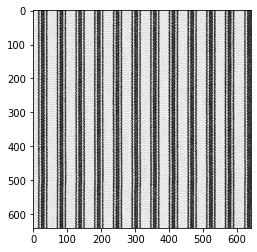

In [3]:
plt.imshow(img_gray, cmap='Greys_r')

# GLCM

Реализацию расчета GLCM и некоторых признаков можно взять из библиотеки skimage:

In [4]:
import skimage.feature as feature

In [5]:
@ipywidgets.interact(
    distance=ipywidgets.IntSlider(min=1, max=100, step=1, value=1),
    angle=ipywidgets.IntSlider(min=-180, max=180, step=1, value=0)
)
def play_with_glcm(distance, angle):
    glcm = feature.greycomatrix(img_gray, [distance], [angle * np.pi / 180], levels=256)
    plt.imshow(glcm[:, :, 0, 0], cmap='coolwarm')

interactive(children=(IntSlider(value=1, description='distance', min=1), IntSlider(value=0, description='angle…

## Вопрос 1

Как по полутоновой матрице смежности определить период текстуры? Чему примерно он равен на рисунке выше (вдоль оси X)?

**Ответ:**

In [6]:
glcm = feature.greycomatrix(img_gray, [50], [0], levels=256)

contrast = feature.greycoprops(glcm, 'contrast')
dissimilarity = feature.greycoprops(glcm, 'dissimilarity')
homogeneity = feature.greycoprops(glcm, 'homogeneity')
energy = feature.greycoprops(glcm, 'energy')
correlation = feature.greycoprops(glcm, 'correlation')
ASM = feature.greycoprops(glcm, 'ASM')

print("Contrast: {}".format(contrast))
print("Dissimilarity: {}".format(dissimilarity))
print("Homogeneity: {}".format(homogeneity))
print("Energy: {}".format(energy))
print("Correlation: {}".format(correlation))
print("ASM: {}".format(ASM))

Contrast: [[8769.00970869]]
Dissimilarity: [[69.9390625]]
Homogeneity: [[0.02388795]]
Energy: [[0.00690536]]
Correlation: [[0.15376945]]
ASM: [[4.76839955e-05]]


# Классификация текстур

Сначала определим функцию для загрузки датасета, которая для каждого изображения сразу расчитает его набор признаков:

In [7]:
def load_dtd(path, get_features_fn):
    classes = sorted(os.listdir(os.path.join(path, 'images')))

    rows = []
    name2idx = {}

    for class_name in tqdm(classes):
        folder_path = os.path.join(path, 'images', class_name)
        for img_name in os.listdir(folder_path):
            if not img_name.endswith('.jpg'):
                continue

            img_path = os.path.join(folder_path, img_name)

            img = cv2.imread(img_path)
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            features = get_features_fn(img_gray)

            features['class'] = class_name

            name2idx[img_name] = len(rows)
            rows.append(features)
    
    splits = []

    for split in range(1, 11):
        train_filepath = os.path.join(path, 'labels', 'train{}.txt'.format(split))
        val_filepath = os.path.join(path, 'labels', 'val{}.txt'.format(split))
        test_filepath = os.path.join(path, 'labels', 'test{}.txt'.format(split))

        with open(train_filepath) as f:
            train_ids = list(map(lambda x: name2idx[x.split('/')[-1]], f.read().split()))

        with open(val_filepath) as f:
            val_ids = list(map(lambda x: name2idx[x.split('/')[-1]], f.read().split()))

        with open(test_filepath) as f:
            test_ids = list(map(lambda x: name2idx[x.split('/')[-1]], f.read().split()))

        splits.append((train_ids, val_ids))

    return pd.DataFrame(rows), splits

В качестве примера определим функцию, возвражающую доступные в skimage текстурные характеристики:

In [8]:
def get_features(img_gray):
    dists = [1]
    angles = [np.pi/2]

    props = ['contrast', 'dissimilarity', 'homogeneity', 
             'energy', 'correlation', 'ASM']

    graycom = feature.greycomatrix(img_gray, dists, angles, levels=256)

    features = {}
    for prop in props:
        prop_values = feature.greycoprops(graycom, prop)
        for i, dist in enumerate(dists):
            for j, angle in enumerate(angles):
                features[prop + '_{:.3f}_{:.3f}'.format(dist, angle)] = prop_values[i, j]
    
    return features

In [10]:
df, splits = load_dtd('dtd', get_features)

100%|██████████| 47/47 [01:28<00:00,  1.88s/it]


In [11]:
df.head()

,contrast_1.000_1.571,dissimilarity_1.000_1.571,homogeneity_1.000_1.571,energy_1.000_1.571,correlation_1.000_1.571,ASM_1.000_1.571,class
0,80.299116,5.916334,0.230062,0.026012,0.965624,0.000677,banded
1,78.846658,4.819061,0.284177,0.046925,0.994084,0.002202,banded
2,10.654091,0.652575,0.926753,0.593076,0.979756,0.351739,banded
3,235.726406,10.047708,0.159680,0.017205,0.956560,0.000296,banded
4,0.000000,0.000000,1.000000,0.298442,1.000000,0.089067,banded


In [12]:
df.shape

(5640, 7)

In [13]:
X = df.iloc[:, :-1]
y = df['class']

В качестве модели попробуем случайный лес:

In [14]:
classifier = RandomForestClassifier(100, max_depth=6)

In [15]:
scores = cross_val_score(classifier, X, y, scoring='accuracy', cv=splits, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.8s finished


In [16]:
scores.mean()

0.10819148936170213

## Задание 1

Улучшите модель классификации, добавив дополнительные признаки (в том числе из тех, что рассматриваются в лекции), изменив модель. Целевые показатели метрики accuracy > 0.5.